In [1]:
from googleapiclient.discovery import build
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
api_key='not available'
channel_id='UCGYlNGlloLLZiAL3zBgbMgQ'

In [3]:
youtube = build(
        'youtube', 'v3', developerKey=api_key)

In [4]:
## function to get channel data
def get_upload_id(youtube, channel_id):
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=channel_id
    )
    response = request.execute()
    
    upload_id = response['items'][0]['contentDetails']['relatedPlaylists']['uploads']
    return upload_id

In [5]:
get_upload_id(youtube, channel_id)

'UUGYlNGlloLLZiAL3zBgbMgQ'

In [6]:
upload_id = get_upload_id(youtube, channel_id)

In [7]:
## function to get video id
def get_video_id(youtube, upload_id):
    
    request = youtube.playlistItems().list(
        part="contentDetails",
        playlistId=upload_id,
        maxResults=50
    )
    response = request.execute()
    
    video_ids = []
    
    for i in range(len(response['items'])):
        video_ids.append(response['items'][i]['contentDetails']['videoId'])
    
    next_page_token = response.get('nextPageToken')
    next_page = True
    
    while next_page:
        if next_page_token is None:
            next_page = False
        else:
            request = youtube.playlistItems().list(
                        part="contentDetails",
                        playlistId=upload_id,
                        maxResults=50,
                        pageToken=next_page_token)
            response = request.execute()

            for i in range(len(response['items'])):
                video_ids.append(response['items'][i]['contentDetails']['videoId'])

            next_page_token = response.get('nextPageToken')    
    
    
    return video_ids

In [8]:
video_ids = get_video_id(youtube, upload_id)

In [9]:
## function to get video details
def get_video_details(youtube, video_ids):
    all_video_detail = []
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
                    part="snippet,contentDetails,statistics",
                    id=",".join(video_ids[i:i+50]))
        response = request.execute()
        
        for video in response['items']:
            video_dict = dict(
                            title = video['snippet']['title'],
                            publishedDate = video['snippet']['publishedAt'],
                            channelName = video['snippet']['channelTitle'],
                            views = video['statistics']['viewCount'],
                            likes = video['statistics']['likeCount'],
                            favoriteCount = video['statistics']['favoriteCount'],
                            duration = video['contentDetails']['duration'],
                            comments = video['statistics'].get('commentCount', 0)
            )
            all_video_detail.append(video_dict)
    
    return all_video_detail

In [10]:
all_video_data = get_video_details(youtube, video_ids)

In [11]:
df = pd.DataFrame(all_video_data)
df['publishedDate'] = pd.to_datetime(df['publishedDate']).dt.date
df

,title,publishedDate,channelName,views,likes,favoriteCount,duration,comments
0,From A ZERO To HERO In Stock Market | Harsh Ku...,2022-09-16,Josh Talks,17620,817,0,PT11M54S,77
1,How To Turn Your Weakness Into Your Strength |...,2022-09-15,Josh Talks,15232,508,0,PT14M14S,36
2,Dreams Shatters But Magic Happens | Rahul Ram ...,2022-09-13,Josh Talks,23619,552,0,PT14M53S,23
3,Right Efforts Can Truly Change Lives | Haimant...,2022-09-12,Josh Talks,28152,791,0,PT15M31S,47
4,This Strategy Helped Me Make Crores On The Int...,2022-09-10,Josh Talks,29821,1694,0,PT9M19S,60
...,...,...,...,...,...,...,...,...
661,We Need To Overcome The India Divide To Make A...,2014-11-03,Josh Talks,2944,35,0,PT6M4S,4
662,The Story Behind CJ Calling Himself 'Papa' | P...,2014-10-15,Josh Talks,11567,122,0,PT2M12S,3
663,The Importance Of Listing Our Dreams! | Dhruv ...,2014-10-06,Josh Talks,10124,153,0,PT22M56S,11
664,How To Make A Difference With Just A Laptop? |...,2014-10-06,Josh Talks,10550,201,0,PT10M33S,13


In [12]:
convert_dict = {'comments': int,
                'favoriteCount': int,
                'views': int,
                'likes': int
                }

df = df.astype(convert_dict)



C:\Users\abhi0\AppData\Local\Temp\ipykernel_16688\2687529283.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  growth_of_channel['publishedDate'] = pd.DatetimeIndex(growth_of_channel['publishedDate']).year


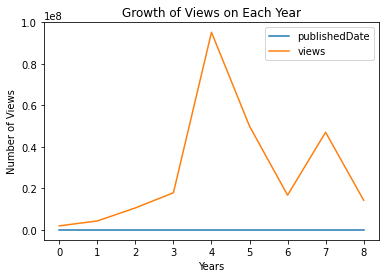

In [13]:
growth_of_channel = df[['publishedDate', 'views']]
growth_of_channel['publishedDate'] = pd.DatetimeIndex(growth_of_channel['publishedDate']).year
growth_of_channel = pd.DataFrame(growth_of_channel.groupby('publishedDate')['views'].sum())
growth_of_channel.reset_index(inplace=True)

growth_of_channel.plot(kind='line')

plt.title('Growth of Views on Each Year')
plt.ylabel('Number of Views')
plt.xlabel('Years')


plt.show() # need this line to show the updates made to the figure

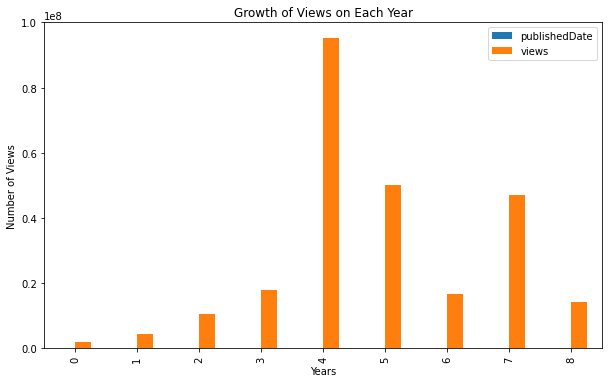

In [14]:
growth_of_channel.plot(kind='bar', figsize=(10, 6))


plt.title('Growth of Views on Each Year')
plt.ylabel('Number of Views')
plt.xlabel('Years')

plt.show()

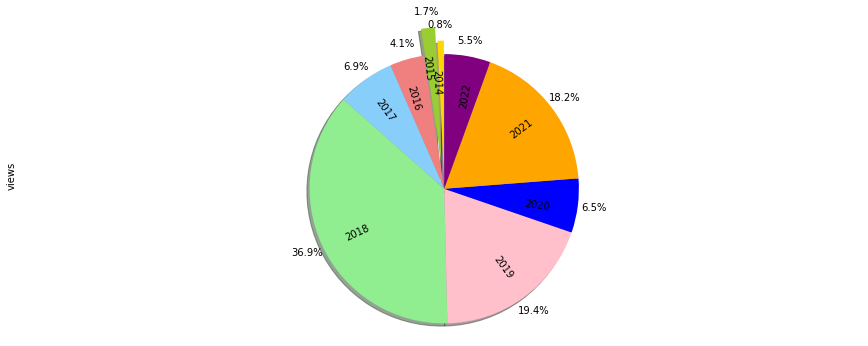

In [15]:
colors_list = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightgreen', 'pink', 'blue', 'orange', 'purple']
explode_list = (0.1, 0.2, 0, 0, 0, 0, 0, 0, 0)


growth_of_channel['views'].plot(kind='pie',
                            figsize=(15, 6),
                            autopct='%1.1f%%', 
                            startangle=90,    
                            shadow=True,       
                            labels=growth_of_channel['publishedDate'],         # turn off labels on pie chart
                            labeldistance=0.6,  
                            rotatelabels =True,    
                            pctdistance=1.12,    # the ratio between the center of each pie slice and the start of the text generated by autopct 
                            colors=colors_list,  # add custom colors
                            explode=explode_list
                            )

plt.title('')
plt.axis("equal")

plt.show()

In [16]:
normal_views = (growth_of_channel['views'] - growth_of_channel['views'].min()) / (growth_of_channel['views'].max() - growth_of_channel['views'].min())

Text(0.5, 1.0, 'Growth of Views on Each Year')

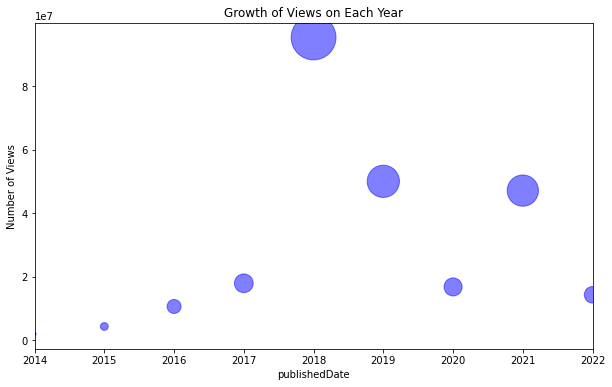

In [17]:
ax0 = growth_of_channel.plot(
    kind='scatter',
    figsize=(10,6),
    color='blue',
    s=normal_views * 2000 + 10,
    xlim=(2014, 2022),
    x='publishedDate',
    y='views',
    alpha=0.5
 )

ax0.set_ylabel('Number of Views')
ax0.set_title('Growth of Views on Each Year')

In [18]:
most_growth = df[pd.to_datetime(df['publishedDate']).dt.year == 2018]
most_growth['publishedDate'] = pd.DatetimeIndex(most_growth['publishedDate']).month
most_growth = most_growth.groupby('publishedDate').sum()
most_growth.reset_index(inplace=True)
most_growth

C:\Users\abhi0\AppData\Local\Temp\ipykernel_16688\208538784.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  most_growth['publishedDate'] = pd.DatetimeIndex(most_growth['publishedDate']).month


,publishedDate,views,likes,favoriteCount,comments
0,1,1311943,36115,0,1733
1,2,13847792,442078,0,15194
2,3,1178424,37594,0,1233
3,4,2809343,63419,0,3331
4,5,6895381,251649,0,6355
5,6,873897,29348,0,1240
6,7,11872192,389778,0,8573
7,8,8891253,331430,0,8798
8,9,8695016,309796,0,8092
9,10,12547663,516225,0,13532


In [19]:
most_growth.sort_values('views', ascending=False).head(10)

,publishedDate,views,likes,favoriteCount,comments
10,11,19835855,822392,0,22741
1,2,13847792,442078,0,15194
9,10,12547663,516225,0,13532
6,7,11872192,389778,0,8573
7,8,8891253,331430,0,8798
8,9,8695016,309796,0,8092
4,5,6895381,251649,0,6355
11,12,6517034,300492,0,7018
3,4,2809343,63419,0,3331
0,1,1311943,36115,0,1733


In [20]:
import datetime
df.set_index('publishedDate')
df[(df['publishedDate']>datetime.date(2018,11,1)) & (df['publishedDate']<datetime.date(2018,11,30))]

,title,publishedDate,channelName,views,likes,favoriteCount,duration,comments
399,The Life and Struggles Of A LADY IPS OFFICER |...,2018-11-29,Josh Talks,2073712,68237,0,PT13M56S,2417
400,How I Overcame Challenges To Become India's Wo...,2018-11-26,Josh Talks,15402939,648833,0,PT9M26S,16539
401,Live Your Dreams: Advice From A Newspaper Vend...,2018-11-21,Josh Talks,68487,3494,0,PT8M22S,141
402,How Our Life Experiences Shape Our Career? | N...,2018-11-20,Josh Talks,55036,1084,0,PT11M52S,31
403,How To Excel in Life? | IES Akhand Swaroop Pan...,2018-11-20,Josh Talks,55495,2658,0,PT44M20S,175
404,Why Successful Entrepreneurs Never Quit? | Ros...,2018-11-17,Josh Talks,37735,1401,0,PT7M57S,83
405,A Unique Tale Of Becoming An IPS Officer | IPS...,2018-11-15,Josh Talks,440511,25848,0,PT9M1S,1040
406,You Are More Than You Think; Believe In Yourse...,2018-11-14,Josh Talks,198614,12065,0,PT15M26S,626
407,Why Do Most Entrepreneurs Fail? | Saurabh Ubow...,2018-11-12,Josh Talks,33726,1238,0,PT10M57S,56
408,Lessons That Failure And Radio Taught Me | RJ ...,2018-11-08,Josh Talks,47695,1566,0,PT14M50S,75
